# Лабораторная работа №2

Выполнил Сердюков Матвей, ББМО-01-23

## Загрузка датасета GTSRB и установка рабочей директории

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

/home/baksist/.virtualenvs/aszii-lab2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/baksist/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [2]:
%cd $path

/home/baksist/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


/home/baksist/.virtualenvs/aszii-lab2/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Импорт библиотек

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras import layers, models
import pandas as pd

2024-11-24 20:52:11.613187: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-24 20:52:11.622803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732470731.633891   49070 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732470731.637426   49070 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 20:52:11.651995: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
tf.get_logger().setLevel('ERROR')

## Загрузка обучающих и тестовых данных

In [5]:
train_df = pd.read_csv('Train.csv')
train_df['ClassId'] = train_df['ClassId'].astype(str)
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [6]:
test_df = pd.read_csv('Test.csv')
test_df['ClassId'] = test_df['ClassId'].astype(str)
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255, 
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    '.',
    x_col='Path',
    y_col='ClassId',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    train_df,
    '.',
    x_col='Path',
    y_col='ClassId',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    '.',
    x_col='Path',
    y_col='ClassId',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 31368 validated image filenames belonging to 43 classes.
Found 7841 validated image filenames belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.


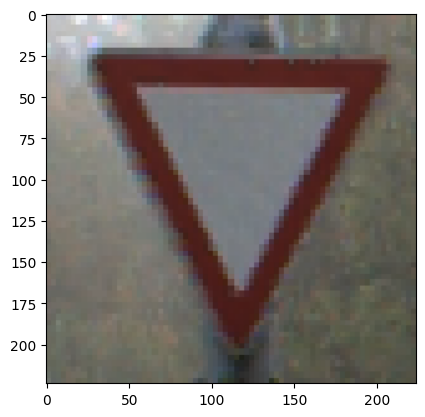

In [9]:
import matplotlib.pyplot as plt

plt.imshow(next(train_generator)[0][0])

## Задание 1.

Обучить 2 классификатора на основе глубоких нейронных сетей на датасете GTSRB.

Использовать следующие модели нейронных сетей: VGG16, ResNet50/10X, MobileNet v2/3. Можно использовать фреймворки Keras, TensorFlow, PyTorch, не надо создавать сети вручную и с нуля.

- Использовать предобученные сети (например на ImageNet).
- Выполнить поиск наилучших гиперпараметров моделей.
- Использовать бесплатные ресурсы GPU сервиса Google Colab.
- Составить отчёт:
  - Заполнить Таблицу 1.
  - Для каждой модели построить графики функции потерь для данных валидации и тестирования и графики метрики Accuracy

In [24]:
resnet_model = ResNet50(weights='imagenet', include_top = False, pooling='avg', input_shape=(224,224,3))
for layer in resnet_model.layers:
    layer.trainable = False

x = resnet_model.output
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(43, activation = 'softmax')(x)

resnet_classifier = models.Model(inputs=resnet_model.input, outputs=predictions)

In [25]:
resnet_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet = resnet_classifier.fit(train_generator, validation_data=validation_generator, epochs=5)

Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 71s 65ms/step - accuracy: 0.0736 - loss: 3.4577 - val_accuracy: 0.0000e+00 - val_loss: 8.5066
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 59s 61ms/step - accuracy: 0.1252 - loss: 3.1768 - val_accuracy: 0.0000e+00 - val_loss: 9.3190
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 60s 61ms/step - accuracy: 0.1604 - loss: 3.0245 - val_accuracy: 0.0000e+00 - val_loss: 11.4573
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 60s 61ms/step - accuracy: 0.1887 - loss: 2.9213 - val_accuracy: 0.0011 - val_loss: 12.6118
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 59s 60ms/step - accuracy: 0.1936 - loss: 2.8738 - val_accuracy: 0.0028 - val_loss: 13.9247


In [26]:
loss, acc = resnet_classifier.evaluate(test_generator)
print('Accuracy: ', acc, '\nLoss    : ', loss)

/home/baksist/.virtualenvs/aszii-lab2/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


394/395 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1992 - loss: 4.9738

2024-11-24 21:26:51.617000: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1710_0', 8 bytes spill stores, 8 bytes spill loads

2024-11-24 21:26:51.881538: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1710', 16 bytes spill stores, 16 bytes spill loads

2024-11-24 21:26:52.497069: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1717_0', 4 bytes spill stores, 4 bytes spill loads

2024-11-24 21:26:52.600722: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1710', 68 bytes spill stores, 68 bytes spill loads



395/395 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.1992 - loss: 4.9740
Accuracy:  0.19707046449184418 
Loss    :  5.0091423988342285


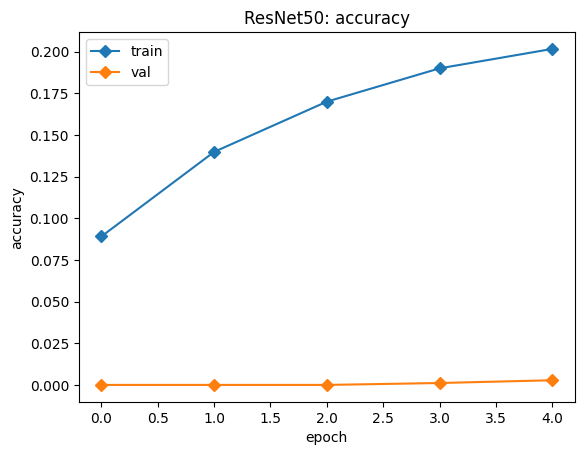

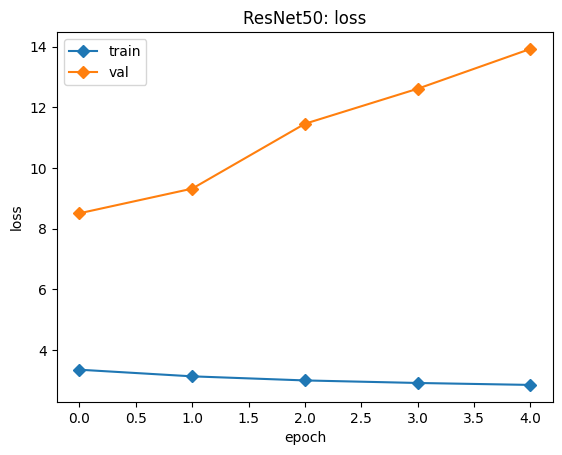

In [27]:
plt.plot(history_resnet.history['accuracy'], marker='D')
plt.plot(history_resnet.history['val_accuracy'], marker='D')
plt.title('ResNet50: accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_resnet.history['loss'], marker='D')
plt.plot(history_resnet.history['val_loss'], marker='D')
plt.title('ResNet50: loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
vgg_model = VGG16(include_top = False, pooling = 'avg',input_shape=(32,32,3))
for layer in vgg_model.layers:
    layer.trainable = False

vgg_classifier = models.Sequential(
    [
        vgg_model,
        layers.Dropout(0.1),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(43, activation = 'softmax')
    ]
)

#vgg_classifier.layers[2].trainable = False
print(vgg_classifier.summary())

In [ ]:
vgg_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_vgg = vgg_classifier.fit(train_generator, epochs=10, batch_size=32, validation_data=test_generator)

In [ ]:
plt.plot(history_vgg.history['accuracy'], marker='D')
plt.plot(history_vgg.history['val_accuracy'], marker='D')
plt.title('model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_vgg.history['loss'], marker='D')
plt.plot(history_vgg.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()